# Защита персональных данных клиентов

**Цели исследования:**

Разработать метод преобразования данных для защиты данных клиентов страховой компании «Хоть потоп», чтобы по ним было сложно восстановить персональную информацию. Обосновать корректность его работы.

Нужно защитить данные, чтобы при преобразовании качество моделей машинного обучения не ухудшилось.

**Ход исследования:**
- Загрузка и изучение данных
- Ответ на вопрос: "Если признаки умножают на обратимую матрицу, изменится ли качество линейной регрессии?"
- Составление алгоритма преобразования данных для решения задачи
    - Обоснование неизменности качества линейной регрессии
    - Реализация алгоритма с помощью матричных операций
    - Проверка качества линейной регрессии методом из sklearn
- Итоговый вывод

**Результаты исследования:**

1. Выяснено, что качество линейной регресии после умножения исходной матрицы признаков на обратимую матрицу-ключ не изменилось, было статистически и аналитически показано, почему это так.
2. Предложен, обоснован и реализован алгоритм преобразования исходных признаков с помощью матрицы-ключа, позволяющий кодировать исходные данные и строить линейную регрессию по закодированным данным.
3. Алгоритм протестирован с использованием кодированных и некодированных признаков, получены практически идентичные результаты (по коэффициенту $R^2$), что значит, что алгоритм шифрования признаков не приводит к значимому ухудшению метрик качества линейной регресии.

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

## Загрузка и изучение данных

In [2]:
ins = pd.read_csv('/home/panther/Documents/Deep Learning/datasets/insurance.csv')

In [3]:
ins.head()

,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
0,1,41.0,49600.0,1,0
1,0,46.0,38000.0,1,1
2,0,29.0,21000.0,0,0
3,0,21.0,41700.0,2,0
4,1,28.0,26100.0,0,0


Стандартные статистики распределения признаков:

In [4]:
ins.describe()

,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.499000,30.952800,39916.360000,1.194200,0.148000
std,0.500049,8.440807,9900.083569,1.091387,0.463183
min,0.000000,18.000000,5300.000000,0.000000,0.000000
25%,0.000000,24.000000,33300.000000,0.000000,0.000000
50%,0.000000,30.000000,40200.000000,1.000000,0.000000
75%,1.000000,37.000000,46600.000000,2.000000,0.000000
max,1.000000,65.000000,79000.000000,6.000000,5.000000


Распределение признаков:

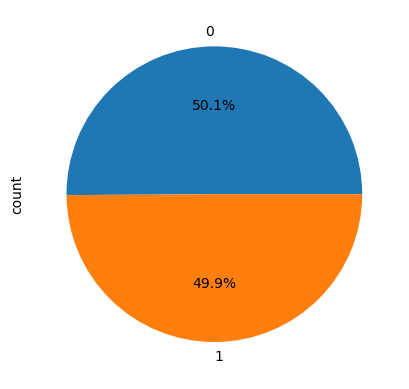

In [5]:
ins['Пол'].value_counts().plot.pie(autopct='%1.1f%%');

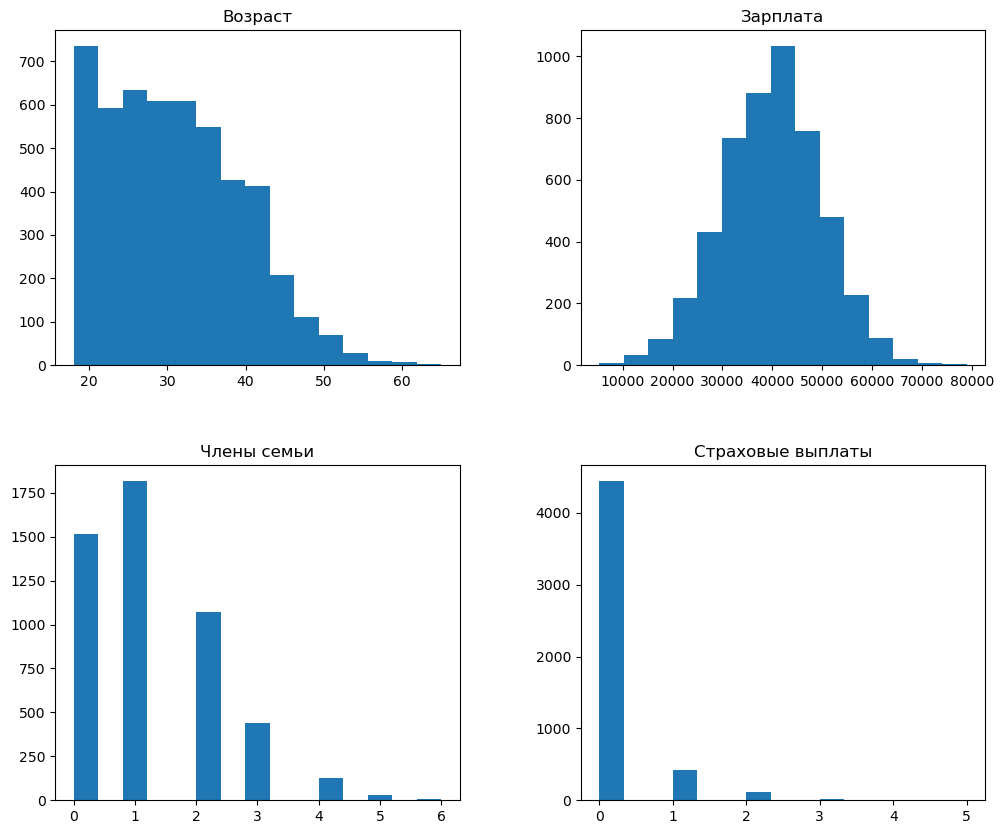

In [6]:
ins.loc[:, 'Возраст':].hist(bins=15, figsize=(12, 10), grid=False);

Аномальных значений не выявлено 

In [7]:
ins.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Пол                5000 non-null   int64  
 1   Возраст            5000 non-null   float64
 2   Зарплата           5000 non-null   float64
 3   Члены семьи        5000 non-null   int64  
 4   Страховые выплаты  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


Найдены значения в типе float, хотя срез данных показывает, что это скорее всего int. Проверяю:

In [8]:
for col in ['Возраст', 'Зарплата']:
    print(f'В столбце \'{col}\' отсутствуют числа с ненулеовой дробной частью: {(ins[col].round(10) % 1  == 0).all()}')

В столбце 'Возраст' отсутствуют числа с ненулеовой дробной частью: True
В столбце 'Зарплата' отсутствуют числа с ненулеовой дробной частью: True


Значения, округленные до 10-го знака после запятой (чтобы избежать погрешности хранения float в памяти), показывают, что в колонках `Возраст` и `Зарплата` хранятся только целые числа. Привожу типы в порядок:

In [9]:
ins[['Возраст', 'Зарплата']] = ins[['Возраст', 'Зарплата']].astype('int')
ins.dtypes

Пол                  int64
Возраст              int64
Зарплата             int64
Члены семьи          int64
Страховые выплаты    int64
dtype: object

Попарное распределение признаков:

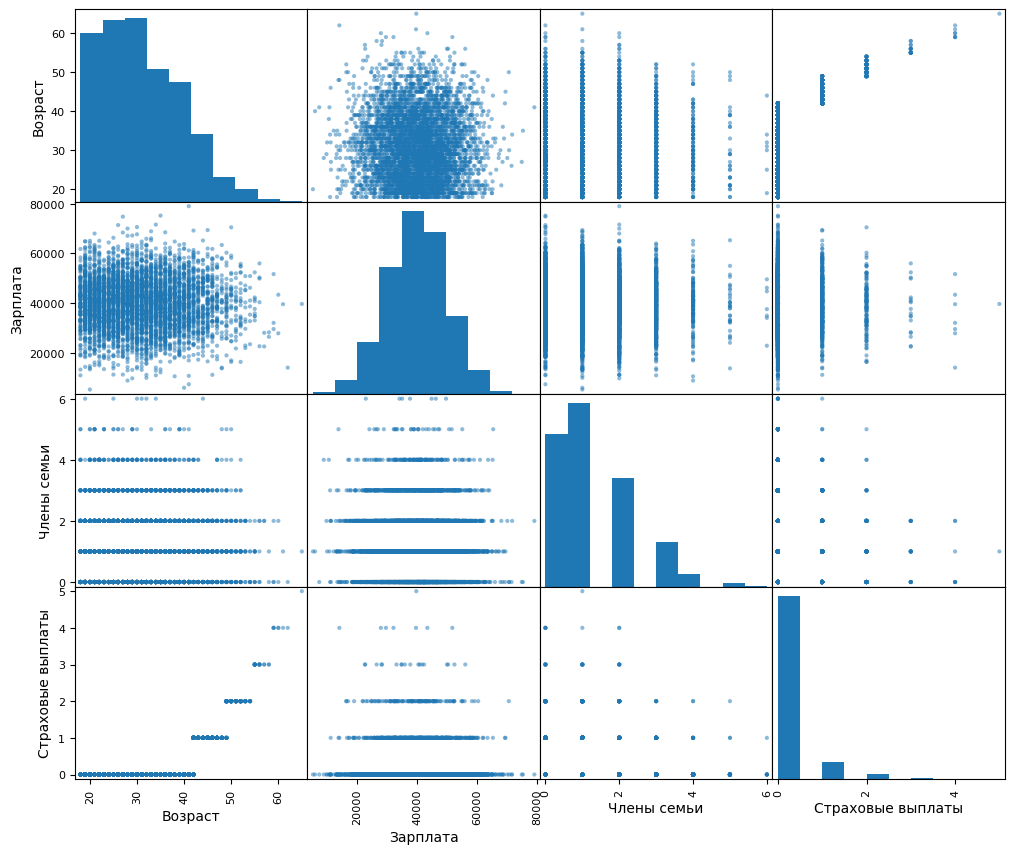

In [10]:
pd.plotting.scatter_matrix(ins.loc[:, 'Возраст':], figsize=(12, 10));

Корреляционная матрица:

In [11]:
ins.loc[:, 'Возраст':].corr().style.background_gradient(cmap='Blues')

,Возраст,Зарплата,Члены семьи,Страховые выплаты
Возраст,1.000000,-0.019093,-0.006692,0.651030
Зарплата,-0.019093,1.000000,-0.030296,-0.014963
Члены семьи,-0.006692,-0.030296,1.000000,-0.036290
Страховые выплаты,0.651030,-0.014963,-0.036290,1.000000


### Вывод, загрузка и изучение данных
- Данные из файла `insurance.csv` были прочитаны в датафрейм `ins`
- В данных 5000 строк и 5 столбцов с признаками: (`Пол`, `Возраст`, `Зарплата`, `Члены семьи`, `Страховые выплаты`)
- Аномальных значений в распределени признаков не найдено
- Неверно определенные типы данных в столбцах `Возраст` и `Зарплата` были переопределены с `float` в `int`
- Диаграммы рассеянья и корреляционная матрица указывают на положительную линейную связь параметров `Страховых выплат` и `Возраста`. Мультиколлинеарных признаков не выявлено.

## Умножение матриц

**Признаки умножают на обратимую матрицу. Изменится ли качество линейной регрессии?**


Обозначения:

- $X$ — матрица признаков (нулевой столбец состоит из единиц)

- $y$ — вектор целевого признака

- $P$ — матрица, на которую умножаются признаки

- $w$ — вектор весов линейной регрессии (нулевой элемент равен сдвигу)

Предсказания:

$$
a = Xw
$$

Задача обучения:

$$
w = \arg\min_w MSE(Xw, y)
$$

Формула обучения:

$$
w = (X^T X)^{-1} X^T y
$$

**Эксперимент**

Разделяю данные признаки и целевой признак

In [12]:
features = ins.drop("Страховые выплаты", axis=1).values
target = ins["Страховые выплаты"].values

Получение baseline показателя $R^2$ для линейной регрессии с помощью метода LinearRegression из модуля sklearn

In [13]:
model = LinearRegression()
model.fit(features, target)
pred = model.predict(features)
true_r2 = r2_score(target, pred)
true_r2

0.42494550308169177

Подсчет абсолютных отклонений оценок $R^2$, полученных после умножения на матрицу, от baseline оценки $R^2$, полученной выше.

In [14]:
def mae(target, pred):
    '''Mean Absolute Error для одного целевого значения и множества предсказанных'''
    return np.mean([np.abs(p - target) for p in pred])

In [15]:
scores = []
X = features
y = target
for i in range (1000):
    P = np.random.rand(min(X.shape), min(X.shape))
    XP = X @ P
    model.fit(XP, y)
    pred_implicit = model.predict(XP)
    scores.append(r2_score(y, pred_implicit))
print(f'MAE отклонение показателя R2 для реальной и преобразованной матрицы признаков: {mae(true_r2, scores):.20f}')

MAE отклонение показателя R2 для реальной и преобразованной матрицы признаков: 0.00000000000004171097


**Ответ:** по результатам эксперимента можно заключить, что умножение на матрицу не влияет на качество работы линейной регрессии, то есть качество линейной регрессии **не изменится**. 

**Обоснование:** 
 - Статистическое: было проведено 1000 замеров показателя $R^2$ на разных, случайно сгенерированных матрицах $P$, МАЕ отклонение коэффициента $R^2$ для реальных признаков от $R^2$ для признаков, "зашифрованных" методом умножения на матрицу, равняется 0 до 13-го знака после запятой.
 
 
 - Аналитическое: 
 
 Неизменность качества предполагает равенство предсказанных значений. Необходимо доказать, что $a = X w = XP w_p $, где $w_p  = ((XP)^T XP)^{-1} (XP)^T y$
 
Допустим, что матрица $P$ обратима, тогда:
$$X w = X \color{green}{P P^{-1}}(X^T X)^{-1} \color{green}{(P^T)^{-1} P^T } X^T y = $$
$$XP P^{-1} (X^T X)^{-1} (P^T)^{-1} (XP)^T y = $$
$$XP P^{-1}(P^T (X^T X))^{-1} (XP)^T y =$$
$$XP (P^T (X^T X) P)^{-1} (XP)^T y =$$
$$XP ((XP)^T XP)^{-1} (XP)^T y =$$
$$XP w_p \blacksquare$$

Зеленым цветом выделены операции, приводящие к единичной матрице, что позволяет их беспрепятственно вводить в выражение.

## Алгоритм преобразования

**Алгоритм**

1. Сгенерировать случайную матрицу-ключ $P$ размерности n+1 x n+1 (по количеству столбцов в **дополненной**  матрице признаков).
2. Дополнить матрицу признаков столбцом единиц для свободного параметра $w_0$
3. Проверить матрицу $P$ на обратимость.
4. Зашифровать матрицу признков $X$, для чего надо:
    - Домножить дополненную матрицу признаков $X$ размерности m x n+1 на случайно сгенерированную матрицу-ключ $P$.
    - Сформировать новый вектор весов $w_p$, решив задачу $w_p = ((XP)^T XP)^{-1} (XP)^T y $
5. Посчитать предсказания линейной регрессии
    - По незакодированной матрице $X$ и вектору весов $w$
    - По закодированной матрице $XP$ и вектору весов $w_p$
6. Сравнить полученные оценки подсчетом коэффициента $R^2$

**Обоснование**

1. Случайно сгенеированная матрица исключит системность в выборе компонентов матрицы, таким образом подобрать "ключ" к данным будет сложнее. Размерность определяется необходимостью перемножения с расширенной матрицей признаков, а квадратность - необходимостью гарантированной обратимости.
2. Позволит не считать влияние $w_0$ отдельно
3. Для необратимых матриц нельзя посчитать $w$, поэтому обратимость надо проверить. Не все квадратные матрицы обратимы.
4. Получаем "зашифрованную" матрицу признаков умножением на матрицу-ключ
5. , 6. Для оценки эффективности и точности алгоритма нужен baseline и метрика качества. 


**Реализация алгоритма**

In [16]:
def linear_regression_encoder(features, target, key, encode=True):
    '''Считает линейную регрессию в зашифрованном и чистом виде
    Вход:
            features - матрица признаков
            target - вектор целевого признака
            key - матрица-ключ
            encode - осуществлять ли кодирование ключом
    Выход:
            pred_real, pred_encoded - реальные и зашифрованные предсказания
    '''
    if (np.linalg.det(key)):
        X = np.hstack((np.ones((features.shape[0], 1)), features))
        pred_real = X @ np.linalg.inv(X.T @ X) @ X.T @ target 
        
        if encode:
            XP = X @ key
            pred_encoded = XP @ np.linalg.inv(XP.T @ XP) @ XP.T @ target
            return pred_real, pred_encoded
        
        return pred_real
    
    else:
        print("Необратимая матрица, явный подсчет линейной регрессии невозможен")

## Проверка алгоритма

Генерация случайной матрицы-ключа

In [17]:
np.random.seed(42)
K = np.random.randint((features.shape[1]+1) ** 2, size=(features.shape[1]+1, features.shape[1]+1))
K

array([[ 6, 19, 14, 10,  7],
       [20,  6, 18, 22, 10],
       [10, 23, 20,  3,  7],
       [23,  2, 21, 20,  1],
       [23, 11,  5,  1, 20]])

In [18]:
pred_real, pred_encoded = linear_regression_encoder(features, target, K)
pred_real_r2 = r2_score(target, pred_real)
pred_encoded_r2 = r2_score(target, pred_encoded)
print('R2 линейной регрессии, посчитанной в явном виде:')
print(f'\tНекодированные признаки: {pred_real_r2:.10f}' )
print(f'\tКодированные признаки: {pred_encoded_r2:.10f}' )

R2 линейной регрессии, посчитанной в явном виде:
	Некодированные признаки: 0.4249455031
	Кодированные признаки: 0.4249453831


In [19]:
final_table = pd.DataFrame({'Модель': ['LR sklearn (baseline)', 'Explicit LR', 'Explicit LR (encoded)'],
                           'Результат R2': [true_r2, pred_real_r2, pred_encoded_r2]}).set_index('Модель')

## Итоговый вывод

В ходе работы был разработан и обоснован метод защиты данных для компании "Хоть потоп".

Было получены следующие результаты:
1. Выяснено, что качество линейной регресии после умножения исходной матрицы признаков на обратимую матрицу-ключ не изменилось, было статистически и аналитически показано, почему это так.
2. Предложен, обоснован и реализован алгоритм преобразования исходных признаков с помощью матрицы-ключа, позволяющий кодировать исходные данные и строить линейную регрессию уже по кодированным.
3. Алгоритм протестирован с использованием кодированных и некодированных признаков, получены следующие результаты:

In [20]:
final_table

,Результат R2
Модель,
LR sklearn (baseline),0.424946
Explicit LR,0.424946
Explicit LR (encoded),0.424945


Очевидно, что результаты по коэффициенту $R^2$ почти идентичны (равны вплоть до 6-го знака после запятой), из чего можно заключить, что алгоритм шифрования признаков не приводит к значимому ухудшению метрик качества линейной регресии.